### Examining payments (within the vendor payments dataset) of the same amount, to the same vendor, on the same day, with the same committment name, as well as the same department description.

In [70]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)


In [71]:
# plt.rcParams.update(plt.rcParamsDefault)

In [72]:
# import csv data
files = glob.glob('data/cleaned_data/*.csv')

payments = pd.concat([pd.read_csv(f, dtype={'commitmt_item_name': 'str', 'dept._descrptn': 'str', 'vendor_name': 'str'}) \
                      for f in files], sort=True)

In [73]:
# examine data types that have been imported
payments.dtypes

check/payment_date     object
commitmt_item_name     object
dept._descrptn         object
invoice_net_amt       float64
vendor_name            object
dtype: object

In [74]:
payments.head()

,check/payment_date,commitmt_item_name,dept._descrptn,invoice_net_amt,vendor_name
0,2014-01-02,Inventories,Street Transportation,-34.78,3M COMPANY
1,2014-01-02,Inventories,Street Transportation,-69.55,3M COMPANY
2,2014-01-02,Inventories,Street Transportation,-77.00,3M COMPANY
3,2014-01-02,Inventories,Public Works,0.01,AGS SAFETY & SUPPLY
4,2014-01-02,Inventories,Police,-0.79,AMERICAN EUROCOPTER CORPORATION


In [75]:
# convert check/payment date into datetime, it was imported as an object
payments.iloc[:,0] = pd.to_datetime(payments.iloc[:,0])

In [76]:
# examine date range of data
print(payments.iloc[:,0].min())
print(payments.iloc[:,0].max())

2014-01-02 00:00:00
2018-12-31 00:00:00


In [77]:
# create Day_of_Year column to perform time series analysis over the year
payments['day_of_year'] = payments['check/payment_date'].dt.dayofyear

# create Year column to perform annual time series analysis
payments['year'] = payments['check/payment_date'].dt.year

# create Year/Month column
payments['year_month'] = payments['check/payment_date'].apply(lambda x: str(x.year) + '.' + str(x.month).zfill(2))

In [78]:
payments.head()

,check/payment_date,commitmt_item_name,dept._descrptn,invoice_net_amt,vendor_name,day_of_year,year,year_month
0,2014-01-02,Inventories,Street Transportation,-34.78,3M COMPANY,2,2014,2014.01
1,2014-01-02,Inventories,Street Transportation,-69.55,3M COMPANY,2,2014,2014.01
2,2014-01-02,Inventories,Street Transportation,-77.00,3M COMPANY,2,2014,2014.01
3,2014-01-02,Inventories,Public Works,0.01,AGS SAFETY & SUPPLY,2,2014,2014.01
4,2014-01-02,Inventories,Police,-0.79,AMERICAN EUROCOPTER CORPORATION,2,2014,2014.01


### Find identical payments that are larger then 5 dollars in amount, and also smaller than 1,000 dollars.  My reasoning being if fraud is take place, it probably is within this range.  Amounts of greater than 1000 dollars often require many levels of approval.

In [79]:
# exclude payments of less than $5
# find vendors that have the highest number of identical payments
identical_pay_group = payments[payments['invoice_net_amt'] > 5].groupby(['check/payment_date',
     'commitmt_item_name',
     'dept._descrptn',
     'invoice_net_amt',
     'vendor_name']).size().reset_index()

In [80]:
# how many vendors have more than 20 payments of the same amount on the same day?
# payment amounts are less than $1,000 (a few extreme outliers were proving troublesome)
identical_pay_group[(identical_pay_group[0] > 20) & (identical_pay_group['invoice_net_amt'] < 1000)].shape

(929, 6)

In [81]:
identical_pay_group.head()

,check/payment_date,commitmt_item_name,dept._descrptn,invoice_net_amt,vendor_name,0
0,2014-01-02,3rd Party Relocation,Aviation,98598.20,SECURITY TITLE AGENCY,1
1,2014-01-02,A/C Chilled Wtr Svc,Phoenix Convention Center,14038.18,NRG THERMAL LLC,1
2,2014-01-02,A/C Chilled Wtr Svc,Phoenix Convention Center,39182.73,NRG THERMAL LLC,1
3,2014-01-02,A/C Chilled Wtr Svc,Phoenix Convention Center,57307.33,NRG THERMAL LLC,1
4,2014-01-02,A/C Chilled Wtr Svc,Phoenix Convention Center,64578.31,NRG THERMAL LLC,1


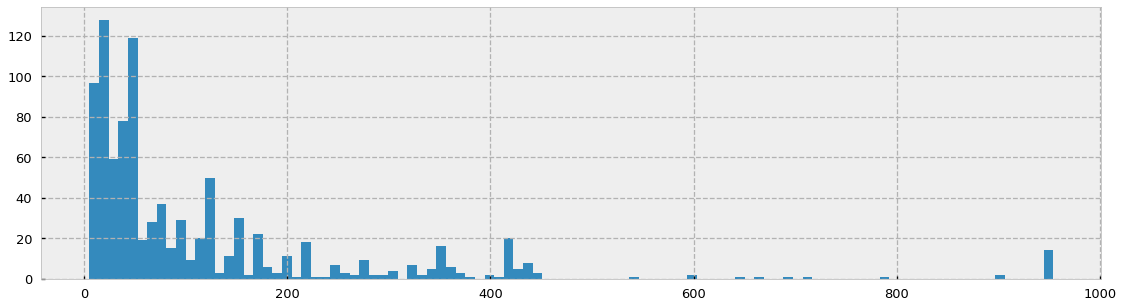

In [82]:
# graph payments as a histogram
fig, ax = plt.subplots(figsize=(19, 5))
identical_pay_group[(identical_pay_group[0] > 20) & (identical_pay_group['invoice_net_amt'] < 1000)]['invoice_net_amt'].hist(bins=100)

Text(0, 0.5, 'Payment Amount($)')

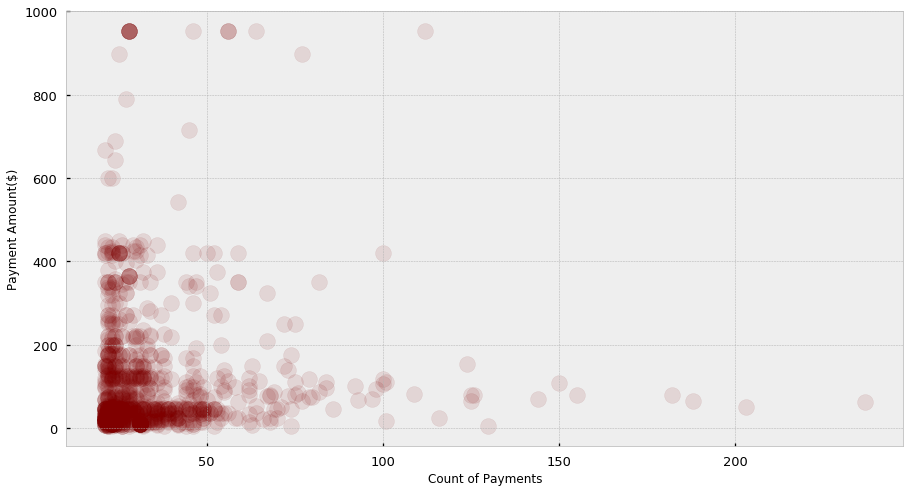

In [83]:
plt.figure(figsize=(15, 8))
# plt.style.use('ggplot')
# plt.style.use('seaborn-talk')

plt.style.use('bmh')

# graph payment amount on y axis
# graph payment count on x axis
plt.scatter(identical_pay_group[(identical_pay_group[0] > 20) 
                                & (identical_pay_group['invoice_net_amt'] < 1000)].iloc[:,5],
            identical_pay_group[(identical_pay_group[0] > 20) 
                                & (identical_pay_group['invoice_net_amt'] < 1000)]['invoice_net_amt'],
           alpha=.1,
           s=250,
           color='maroon')

plt.xlabel("Count of Payments")
plt.ylabel("Payment Amount($)")

# plt.savefig("visualizations/identical_payments_less_than_1000.png")

(20, 75)

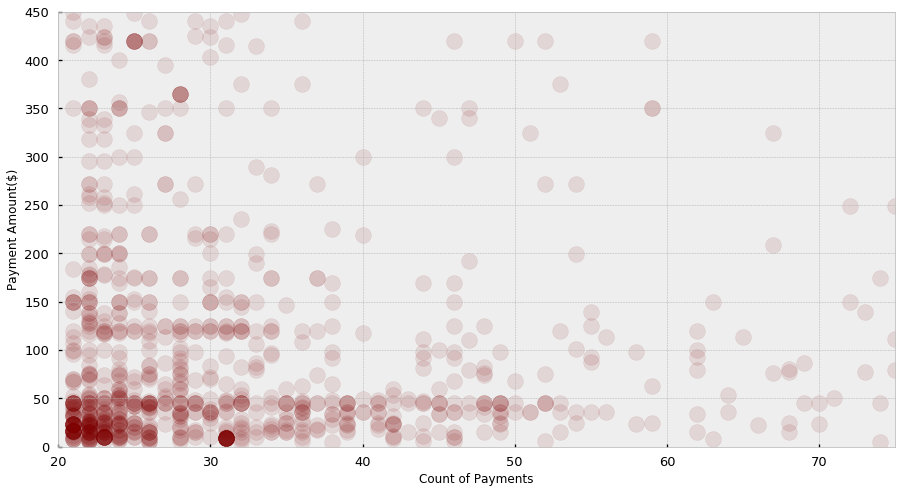

In [84]:
plt.figure(figsize=(15, 8))
plt.style.use('bmh')

# graph payment amount on y axis
# graph payment count on x axis
plt.scatter(identical_pay_group[(identical_pay_group[0] > 20) 
                                & (identical_pay_group['invoice_net_amt'] < 1000)].iloc[:,5],
            identical_pay_group[(identical_pay_group[0] > 20) 
                                & (identical_pay_group['invoice_net_amt'] < 1000)]['invoice_net_amt'],
           alpha=.1,
           s=250,
           color='maroon')

plt.xlabel("Count of Payments")
plt.ylabel("Payment Amount($)")

plt.ylim(0,450)
plt.xlim(20,75)

# plt.savefig("visualizations/identical_payments_less_than_1000_reduced_$450.png")

### For the top 30 vendors with duplicate payments between 5 and 1000 dollars, how are the duplicate payments distributed?

In [85]:
top_30 = identical_pay_group[(identical_pay_group[0] > 10) & \
                    (identical_pay_group['invoice_net_amt'] < 1000)]['vendor_name'].value_counts().head(30)

In [86]:
top_30.index

Index(['CREATIVE COMMUNICATIONS', 'WESTERN TOWING',
       'COMMUNITY TIRE PROS & AUTO REPAIR', 'CITY WIDE PEST CONTROL',
       'MISSION UNIFORM SERVICES', 'AKERS PEST CONTROL', 'ALL CITY TOWING',
       'ARIZONA UNIFORM & APPAREL', 'EUROFINS EATON ANALYTICAL INC',
       'THYSSENKRUPP ELEVATOR CORP', 'MARICOPA COUNTY ENVIRONMENTAL',
       'EMERGENCY RESTORATION EXPERTS LLC', 'RCI SYSTEMS, INC',
       'SOMERSET LANDSCAPE MAINTENANCE', 'FRIENDLY HOUSE INC',
       'AUTO GLASS & TINT DIRECT LLC', 'VULCAN MATERIAL CO - WESTERN D',
       'MATHESON TRI-GAS INC', 'PHOENIX TIRE INC',
       'Court Restitution: Name withheld', 'HEALY'S RED WING SHOE STORES',
       'SELECT GLASS INC', 'NEIGHBORHOOD HOUSING SERVICES', 'DELTA BAP INC',
       'PHOENIX HISPANIC NETWORK', 'FLUORESCO SERVICES LLC',
       'MORALES-SHERMAN LANGUAGES', 'MSE CORPORATE SECURITY INC',
       'ALTITUDE LAB SOLUTIONS LLC', 'UNITED FIRE EQUIP CO'],
      dtype='object')

In [87]:
# top 15 vendors with identical payments greater than 5 and less than 1000, with groupings greater than 20
identical_pay_group[(identical_pay_group[0] > 10) & \
                    (identical_pay_group['invoice_net_amt'] < 1000) & \
                    (identical_pay_group['vendor_name'].isin(top_30.index))].head()

,check/payment_date,commitmt_item_name,dept._descrptn,invoice_net_amt,vendor_name,0
2769,2014-01-06,Rel Adv Svcs-TrnAsst,Aviation,50.33,NEIGHBORHOOD HOUSING SERVICES,203
2770,2014-01-06,Rel Adv Svcs-TrnAsst,Aviation,50.34,NEIGHBORHOOD HOUSING SERVICES,71
3774,2014-01-07,Trust-Court-Prob Res,Municipal Court,100.00,Court Restitution: Name withheld,15
5155,2014-01-09,Motor Vehicle Repair,Public Works,19.99,AUTO GLASS & TINT DIRECT LLC,22
5158,2014-01-09,Motor Vehicle Repair,Public Works,45.00,AUTO GLASS & TINT DIRECT LLC,48


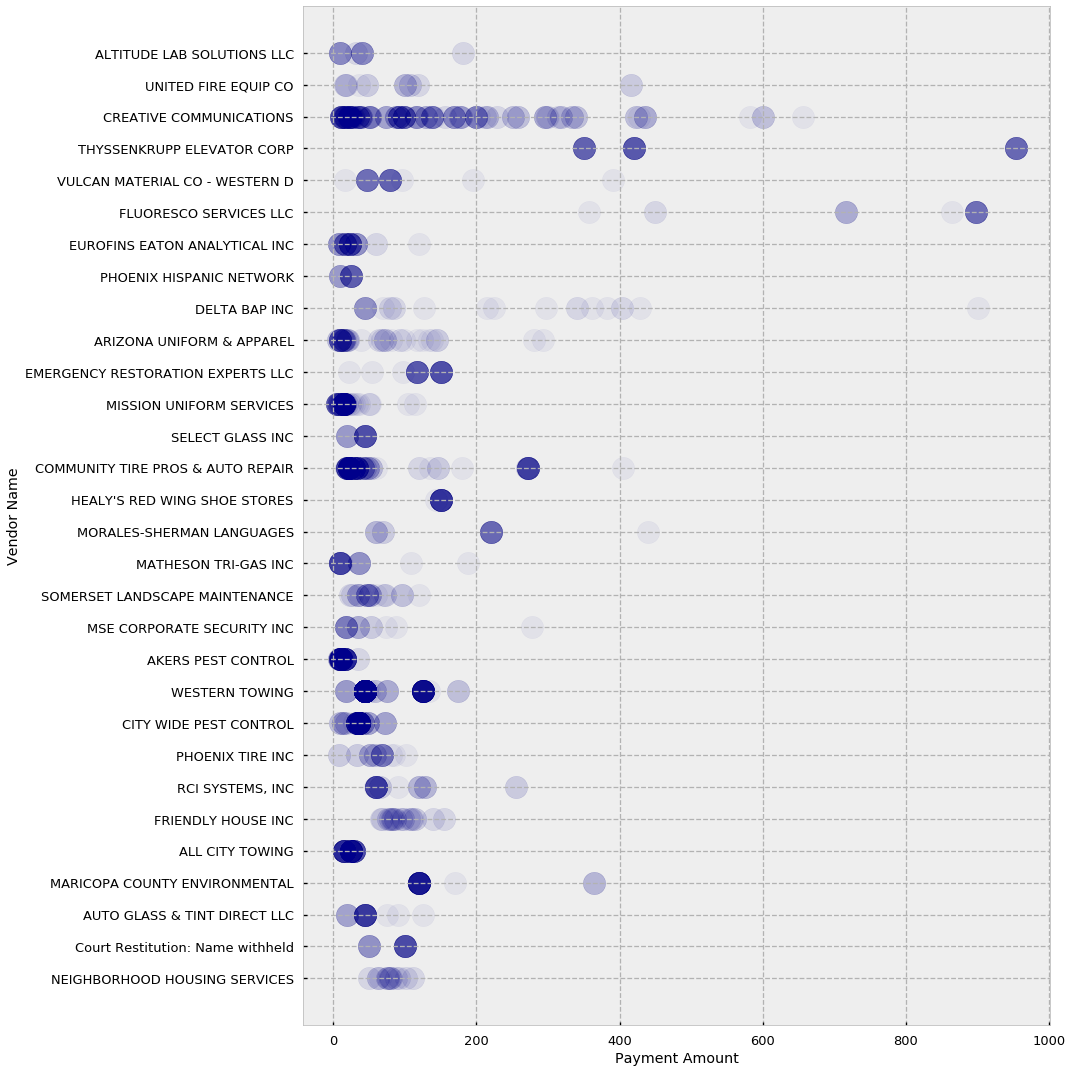

In [101]:
plt.figure(figsize=(15, 15))
# plt.style.use('ggplot')


plt.style.use('bmh')
plt.style.use('seaborn-talk')
# graph payment amount on y axis
# graph payment count on x axis
plt.scatter(identical_pay_group[(identical_pay_group[0] > 10) & \
                    (identical_pay_group['invoice_net_amt'] < 1000) & \
                    (identical_pay_group['vendor_name'].isin(top_30.index))].iloc[:,3],
            identical_pay_group[(identical_pay_group[0] > 10) & \
                    (identical_pay_group['invoice_net_amt'] < 1000) & \
                    (identical_pay_group['vendor_name'].isin(top_30.index))].iloc[:,4],
           alpha=.05,
           s=500,
           color='darkblue')

plt.xlabel("Payment Amount")
plt.ylabel("Vendor Name")
plt.tight_layout()
plt.savefig("visualizations/identical_payments_less_than_1000_top_30_vendors.png")

### Find the top 5 vendors, how are their payments distributed?

In [89]:
# find top 5 vendors within above grouping 
identical_pay_group[(identical_pay_group[0] > 20) & (identical_pay_group['invoice_net_amt'] < 1000)] \
    ['vendor_name'].value_counts().head(5)

CREATIVE COMMUNICATIONS              96
WESTERN TOWING                       83
CITY WIDE PEST CONTROL               55
EUROFINS EATON ANALYTICAL INC        48
COMMUNITY TIRE PROS & AUTO REPAIR    43
Name: vendor_name, dtype: int64

In [90]:
# extract just the top 5 vendor names
identical_pay_group[(identical_pay_group[0] > 20) & (identical_pay_group['invoice_net_amt'] < 1000)] \
    ['vendor_name'].value_counts().head(5).index

Index(['CREATIVE COMMUNICATIONS', 'WESTERN TOWING', 'CITY WIDE PEST CONTROL',
       'EUROFINS EATON ANALYTICAL INC', 'COMMUNITY TIRE PROS & AUTO REPAIR'],
      dtype='object')

In [91]:
# subset payments data based on the payments of these top 5 vendors
id_payments_top_vendors = payments[payments['vendor_name'].isin(identical_pay_group[(identical_pay_group[0] > 20) & (identical_pay_group['invoice_net_amt'] < 1000)] \
    ['vendor_name'].value_counts().head(5).index)]

In [92]:
# how many rows?
id_payments_top_vendors.shape

(79833, 8)

### Use dot plots to show dispersion of all payments for top 5 vendors with idential payments

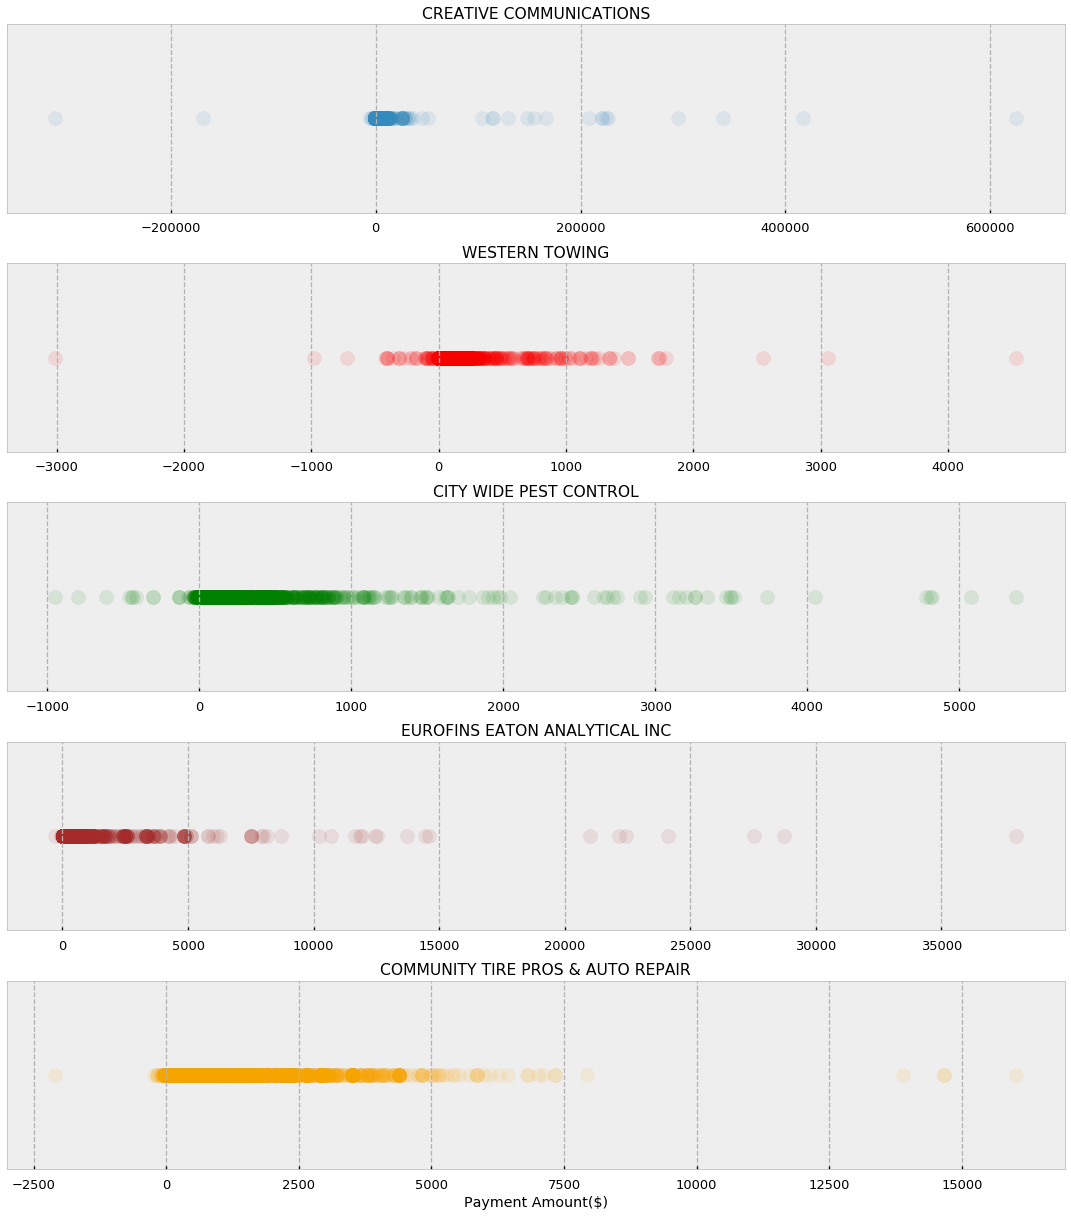

In [93]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 17))

ax[0].scatter(payments[payments['vendor_name'] == 'CREATIVE COMMUNICATIONS']['invoice_net_amt'],
              payments[payments['vendor_name'] == 'CREATIVE COMMUNICATIONS']['invoice_net_amt'].apply(lambda x: x * 0 + 1),
              alpha=.1, 
              s=200)
ax[0].set_title('CREATIVE COMMUNICATIONS')

ax[1].scatter(payments[payments['vendor_name'] == 'WESTERN TOWING']['invoice_net_amt'],
              payments[payments['vendor_name'] == 'WESTERN TOWING']['invoice_net_amt'].apply(lambda x: x * 0 + 1), 
              c='red',
              alpha=.1, 
              s=200)
ax[1].set_title('WESTERN TOWING')

ax[2].scatter(payments[payments['vendor_name'] == 'CITY WIDE PEST CONTROL']['invoice_net_amt'],
                 payments[payments['vendor_name'] == 'CITY WIDE PEST CONTROL']['invoice_net_amt'].apply(lambda x: x * 0 + 1), 
              c='green',
              alpha=.1, 
              s=200)
ax[2].set_title('CITY WIDE PEST CONTROL')

ax[3].scatter(payments[payments['vendor_name'] == 'EUROFINS EATON ANALYTICAL INC']['invoice_net_amt'],
                 payments[payments['vendor_name'] == 'EUROFINS EATON ANALYTICAL INC']['invoice_net_amt'].apply(lambda x: x * 0 + 1), 
              c='brown',alpha=.1, s=200)
ax[3].set_title('EUROFINS EATON ANALYTICAL INC')

ax[4].scatter(payments[payments['vendor_name'] == 'COMMUNITY TIRE PROS & AUTO REPAIR']['invoice_net_amt'],
                 payments[payments['vendor_name'] == 'COMMUNITY TIRE PROS & AUTO REPAIR']['invoice_net_amt'].apply(lambda x: x * 0 + 1), 
              c='orange',alpha=.1, s=200)
ax[4].set_title('COMMUNITY TIRE PROS & AUTO REPAIR')

# remove tick marks on the y-axis
for axis in ax.flat:
    axis.yaxis.set_major_locator(plt.NullLocator())

plt.xlabel("Payment Amount($)")
plt.tight_layout()

# plt.savefig("visualizations/identical_payments_top_5_vendors_distributions.png")

### Graph all payments over time to the top 5 vendors who were paid identical payments.  Limit to only payments under 1,000.

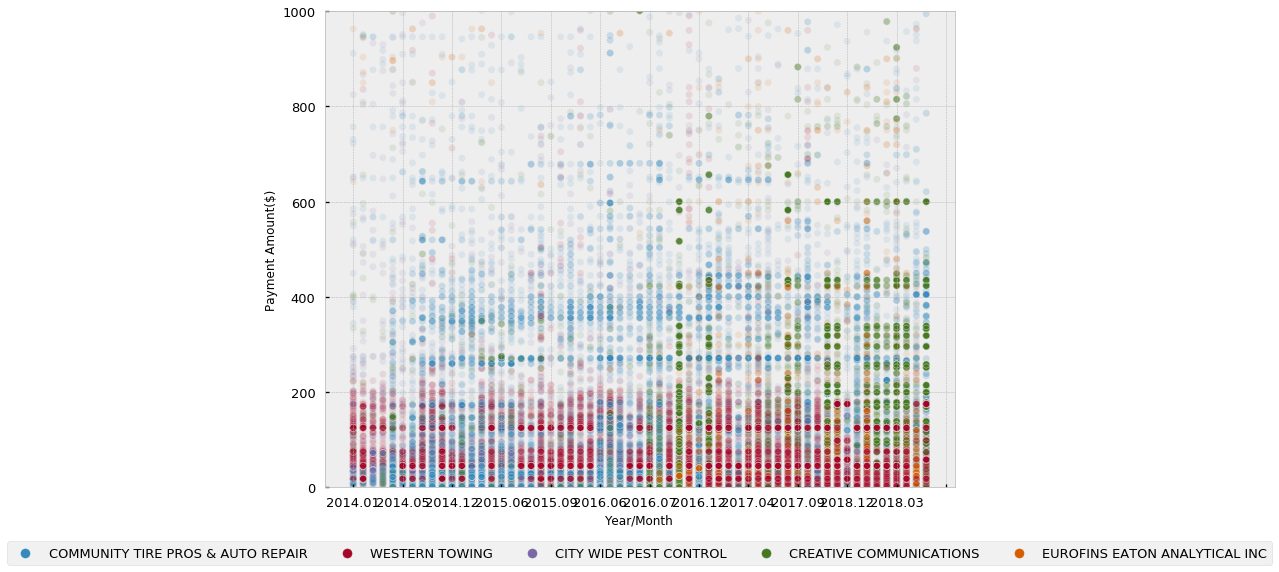

In [94]:
plt.figure(figsize=(15, 8))
plt.style.use('bmh')

ax = sns.scatterplot(x=id_payments_top_vendors.iloc[:,7],
           y=id_payments_top_vendors.iloc[:,3],
           hue=id_payments_top_vendors.iloc[:,4],
           alpha=.1,
           s=50)

plt.xlabel("Year/Month")
plt.ylabel("Payment Amount($)")

ax.xaxis.set_major_locator(ticker.MultipleLocator(5))

plt.ylim(0, 1000)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=5)

plt.tight_layout()
# plt.savefig("visualizations/identical_payments_top_5_vendors_all_payments_graph_under_$1000.png")

### Graph count of identical payments under 1,000 against the payment amount - limit to only the top 5 vendors with idential payments.

In [95]:
id_payments_less_1000 = identical_pay_group[(identical_pay_group[0] > 20) & \
                                            (identical_pay_group['invoice_net_amt'] < 1000)]

In [96]:
id_payments_less_1000.head()

,check/payment_date,commitmt_item_name,dept._descrptn,invoice_net_amt,vendor_name,0
1286,2014-01-02,Prop Management Cost,Aviation,174.39,BERRY REALTY & ASSOC,34
2769,2014-01-06,Rel Adv Svcs-TrnAsst,Aviation,50.33,NEIGHBORHOOD HOUSING SERVICES,203
2770,2014-01-06,Rel Adv Svcs-TrnAsst,Aviation,50.34,NEIGHBORHOOD HOUSING SERVICES,71
5155,2014-01-09,Motor Vehicle Repair,Public Works,19.99,AUTO GLASS & TINT DIRECT LLC,22
5158,2014-01-09,Motor Vehicle Repair,Public Works,45.00,AUTO GLASS & TINT DIRECT LLC,48


In [97]:
top_5_id_payments_less_1000 = id_payments_less_1000[id_payments_less_1000['vendor_name'].isin(identical_pay_group[(identical_pay_group[0] > 20) & (identical_pay_group['invoice_net_amt'] < 1000)] \
    ['vendor_name'].value_counts().head(5).index)]

In [98]:
top_5_id_payments_less_1000.head()

,check/payment_date,commitmt_item_name,dept._descrptn,invoice_net_amt,vendor_name,0
12257,2014-01-21,Pest Control Service,Parks and Recreation,36.0,CITY WIDE PEST CONTROL,41
13921,2014-01-23,Motor Vehicle Repair,Public Works,45.0,WESTERN TOWING,37
13965,2014-01-23,Motor Vehicle Repair,Public Works,125.0,WESTERN TOWING,32
15127,2014-01-24,Motor Vehicle Repair,Public Works,45.0,WESTERN TOWING,22
23407,2014-02-06,Pest Control Service,Parks and Recreation,36.0,CITY WIDE PEST CONTROL,40


In [99]:
id_payments_less_1000[id_payments_less_1000['vendor_name'].isin(identical_pay_group[(identical_pay_group[0] > 20) & (identical_pay_group['invoice_net_amt'] < 1000)] \
    ['vendor_name'].value_counts().head(5).index)].shape

(325, 6)

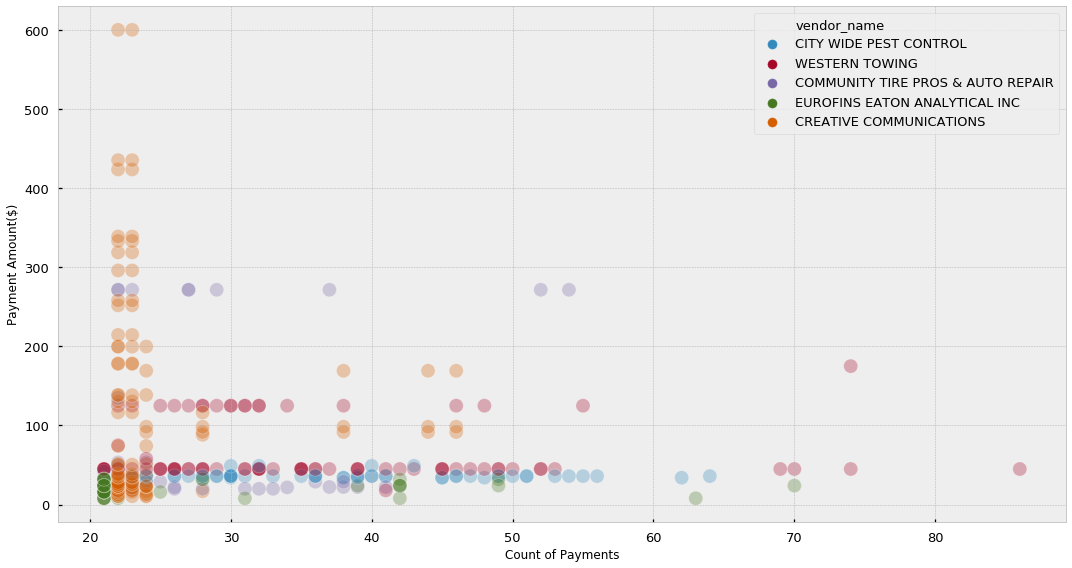

In [100]:
plt.figure(figsize=(15, 8))

sns.scatterplot(x=top_5_id_payments_less_1000.iloc[:,5],
           y=top_5_id_payments_less_1000.iloc[:,3],
           hue=top_5_id_payments_less_1000.iloc[:,4],
           alpha=.3,
               s=200)

plt.xlabel("Count of Payments")
plt.ylabel("Payment Amount($)")

plt.tight_layout()
# plt.savefig("visualizations/identical_payments_top_5_vendors_graph_under_$1000.png")

#### next steps
~~exclude invoices with leading digit of 0~~
1. which departments are most associated with duplicate payments? uniform cleaning?
1. are certain time of the year associated with high volumes of payments to certain vendors?
1. for vendors with more than 50 payments of the same amount on the same day . . .
    - do the leading digits correspond to Benford's law?
    - are thy provide similar goods/services?
1. for vendors with a high number of negative payments . . .
    - year over year, is the volume of negative payments about the same?
    - negative payments as a percentage of total payments
1. vendors with payments at specific times of the year(similar to what I did with the City of Scottsdale vendor payments).
1. vendors with payments within a tight range(essentially a low variance in payment amount).
1. group by dept. description and committment item name, within this combination
which vendors make up the largest share of the spending?
1. 